In [1]:
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt

In [2]:
PLOT_DIR = "/home/biddisco/build/alloc-test/debug/plot/"

In [3]:
# rewrite above code as a function taking the filename as an argument
def read_malloc_output(filename, debug=False):
    # if file does not exist return empty dataframe
    if not os.path.isfile(filename):
        return None

    with open(filename, "r") as hw_file:
        hw_output_text = hw_file.read()

    hw_start_marker = "columns:"
    hw_start_index = hw_output_text.find(hw_start_marker) + len(hw_start_marker)
    hw_table_text = hw_output_text[hw_start_index:]

    # read csv into pandas dataframe, first row is column names
    hw_df = pd.read_csv(io.StringIO(hw_table_text), header=None, delimiter=",", skipinitialspace=True)
    if debug:
        display(hw_df)

    # set column names from first row
    hw_df.columns = list(hw_df.iloc[0, 0::1])
    # drop first row    
    hw_df = hw_df.iloc[1:, 0::1]

    # convert all columns to numeric values
    hw_df = hw_df.apply(pd.to_numeric)
    if debug:
        display(hw_df)
    return hw_df

,0,1,2,3,4,5,6,7,8,9,10
0,thread,duration(ms),duration of void(ms),diff(ms),RSS max(pages),rssAfterExitingAllThreads(pages),RSS max for void(pages),rssAfterExitingAllThreads for void(pages),allocatedAfterSetup(app level in bytes),allocatedMax(app level in bytes),(RSS max<<12)/allocatedMax
1,1,1573,598,975,131968,932,132004,933,536870912,536870917,1.006836
2,2,1447,447,1000,132005,932,132004,936,536870912,536870922,1.007118
3,3,1412,400,1012,131976,914,131954,916,536870880,536870895,1.006897
4,4,1480,371,1109,131988,919,131991,921,536870912,536870932,1.006988
5,5,1378,352,1026,131961,932,131972,944,536870880,536870905,1.006783
6,6,1360,353,1007,131888,906,131946,950,536870880,536870910,1.006226
7,7,1514,341,1173,131990,953,131993,973,536870880,536870915,1.007004
8,8,1438,347,1091,132013,984,131992,964,536870912,536870952,1.007179
9,9,1999,444,1555,132004,947,131987,966,536870880,536870925,1.007111


,thread,duration(ms),duration of void(ms),diff(ms),RSS max(pages),rssAfterExitingAllThreads(pages),RSS max for void(pages),rssAfterExitingAllThreads for void(pages),allocatedAfterSetup(app level in bytes),allocatedMax(app level in bytes),(RSS max<<12)/allocatedMax
1,1,1573,598,975,131968,932,132004,933,536870912,536870917,1.006836
2,2,1447,447,1000,132005,932,132004,936,536870912,536870922,1.007118
3,3,1412,400,1012,131976,914,131954,916,536870880,536870895,1.006897
4,4,1480,371,1109,131988,919,131991,921,536870912,536870932,1.006988
5,5,1378,352,1026,131961,932,131972,944,536870880,536870905,1.006783
6,6,1360,353,1007,131888,906,131946,950,536870880,536870910,1.006226
7,7,1514,341,1173,131990,953,131993,973,536870880,536870915,1.007004
8,8,1438,347,1091,132013,984,131992,964,536870912,536870952,1.007179
9,9,1999,444,1555,132004,947,131987,966,536870880,536870925,1.007111
10,10,1919,493,1426,131846,942,131886,957,536870880,536870930,1.005905


,thread,mimalloc diff,jemalloc diff,tcmalloc diff
1,1,975,840,977
2,2,1000,823,988
3,3,1012,826,989
4,4,1109,826,988
5,5,1026,811,991
6,6,1007,826,1106
7,7,1173,824,989
8,8,1091,824,988
9,9,1555,1144,1453
10,10,1426,1046,1452


<AxesSubplot:title={'center':'Time difference between real malloc and fake malloc'}, xlabel='Threads', ylabel='Time (ms)'>

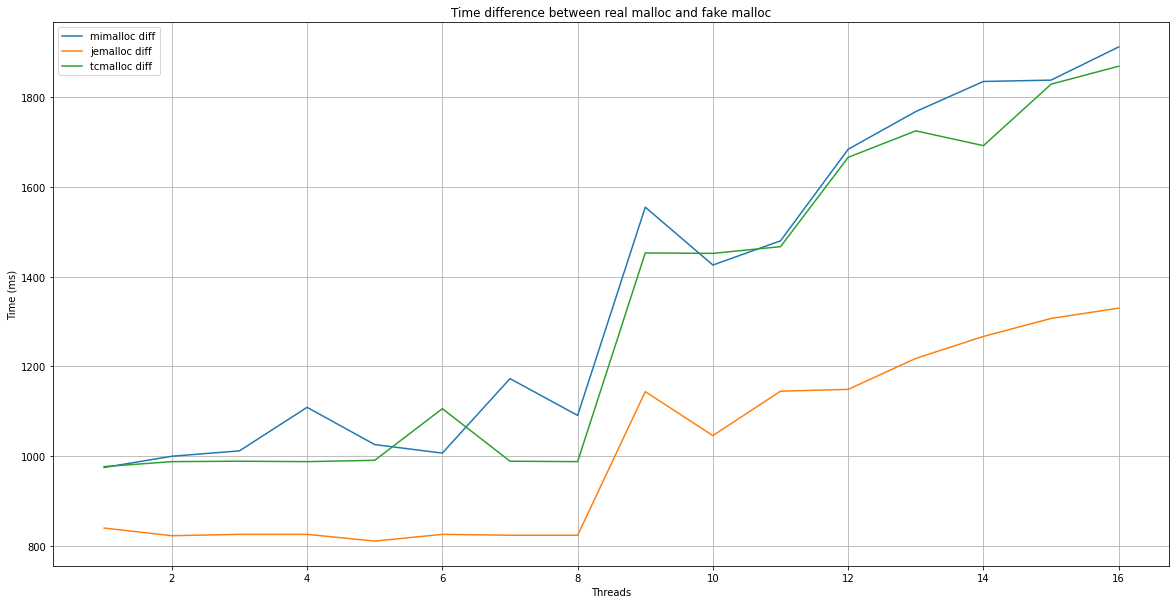

In [4]:
show_debug = True;
results = {}
results["mimalloc"] = read_malloc_output(PLOT_DIR + "test_mimalloc.txt", debug=show_debug)
results["jemalloc"] = read_malloc_output(PLOT_DIR + "test_jemalloc.txt")
results["tcmalloc"] = read_malloc_output(PLOT_DIR + "test_tcmalloc.txt")

# create empty dataframe 
diff = pd.DataFrame()
diff_list = []

for name, df in results.items():
    if df is not None:
        # merge diff column and rename it in the new dataset
        diff = pd.merge(diff, df["thread"], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
        diff.drop(diff.filter(regex='_y$').columns, axis=1, inplace=True)
        # merge thread column and delete it if it is a duplicate (all tests have an identical thread column)
        diff = pd.merge(diff, df["diff(ms)"], left_index=True, right_index=True, how='outer')
        diff.rename(columns={"diff(ms)": name +" diff"}, inplace=True)
        # add valid diff column name to final plot list
        diff_list.append(name +" diff")

if show_debug:
    display(diff)

diff.plot(x='thread', y=diff_list, use_index=True, figsize=(20,10), grid=True, xlabel="Threads", ylabel="Time (ms)", title="Time difference between real malloc and fake malloc")

In [5]:
## For tfmalloc

# Read the output file

with open(PLOT_DIR + "test_tfmalloc.txt", "r") as tf_file:
    tf_output_text = tf_file.read()

# Find the start of the table
tf_start_marker = "columns:"
tf_start_index = tf_output_text.find(tf_start_marker) + len(tf_start_marker)

# Extract the table text
tf_table_text = tf_output_text[tf_start_index:]

# Read the table into a pandas DataFrame without column names
tf_df = pd.read_csv(io.StringIO(tf_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
tf_columns = tf_df.shape[1]
tf_column_arrays = []
for i in range(tf_columns):
    column = htfdf[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    tf_column_arrays.append(column)

tf_thread = tf_column_arrays[0]
tf_duration = tf_column_arrays[1]
tf_duration_of_void = tf_column_arrays[2]
tf_diff = tf_column_arrays[3]
tf_RSSmax = tf_column_arrays[4]
tf_rssAfterExitingAllThreads = tf_column_arrays[5]
tf_RSSmax_void = tf_column_arrays[6]
tf_rssAfterExitingAllThreads_void = tf_column_arrays[7]
tf_allocatedAfterSetup = tf_column_arrays[8]
tf_allocatedMax = tf_column_arrays[9]
tf_RSSmax_over_allocatedMax = tf_column_arrays[10]

FileNotFoundError: [Errno 2] No such file or directory: '/home/biddisco/build/alloc-test/debug/plot/test_tfmalloc.txt'

In [ ]:
## For jemalloc

# Read the output file

with open(PLOT_DIR + "test_jemalloc.txt", "r") as je_file:
    je_output_text = je_file.read()

# Find the start of the table
je_start_marker = "columns:"
je_start_index = je_output_text.find(je_start_marker) + len(je_start_marker)

# Extract the table text
je_table_text = je_output_text[je_start_index:]

# Read the table into a pandas DataFrame without column names
je_df = pd.read_csv(io.StringIO(je_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
je_columns = je_df.shape[1]
je_column_arrays = []
for i in range(je_columns):
    column = je_df[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    je_column_arrays.append(column)

je_thread = je_column_arrays[0]
je_duration = je_column_arrays[1]
je_duration_of_void = je_column_arrays[2]
je_diff = je_column_arrays[3]
je_RSSmax = je_column_arrays[4]
je_rssAfterExitingAllThreads = je_column_arrays[5]
je_RSSmax_void = je_column_arrays[6]
je_rssAfterExitingAllThreads_void = je_column_arrays[7]
je_allocatedAfterSetup = je_column_arrays[8]
je_allocatedMax = je_column_arrays[9]
je_RSSmax_over_allocatedMax = je_column_arrays[10]

In [ ]:
## For fancy jemalloc

# Read the output file

with open(PLOT_DIR + "test_fancy_jemalloc.txt", "r") as fancy_je_file:
    fancy_je_output_text = fancy_je_file.read()

# Find the start of the table
fancy_je_start_marker = "columns:"
fancy_je_start_index = fancy_je_output_text.find(fancy_je_start_marker) + len(fancy_je_start_marker)

# Extract the table text
fancy_je_table_text = fancy_je_output_text[fancy_je_start_index:]

# Read the table into a pandas DataFrame without column names
fancy_je_df = pd.read_csv(io.StringIO(fancy_je_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
fancy_je_columns = fancy_je_df.shape[1]
fancy_je_column_arrays = []
for i in range(fancy_je_columns):
    column = fancy_je_df[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    fancy_je_column_arrays.append(column)

fancy_je_thread = fancy_je_column_arrays[0]
fancy_je_duration = fancy_je_column_arrays[1]
fancy_je_duration_of_void = fancy_je_column_arrays[2]
fancy_je_diff = fancy_je_column_arrays[3]
fancy_je_RSSmax = fancy_je_column_arrays[4]
fancy_je_rssAfterExitingAllThreads = fancy_je_column_arrays[5]
fancy_je_RSSmax_void = fancy_je_column_arrays[6]
fancy_je_rssAfterExitingAllThreads_void = fancy_je_column_arrays[7]
fancy_je_allocatedAfterSetup = fancy_je_column_arrays[8]
fancy_je_allocatedMax = fancy_je_column_arrays[9]
fancy_je_RSSmax_over_allocatedMax = fancy_je_column_arrays[10]

In [ ]:
## For mimalloc

# Read the output file

with open(PLOT_DIR + "test_mimalloc.txt", "r") as mi_file:
    mi_output_text = mi_file.read()

# Find the start of the table
mi_start_marker = "columns:"
mi_start_index = mi_output_text.find(mi_start_marker) + len(mi_start_marker)

# Extract the table text
mi_table_text = mi_output_text[mi_start_index:]

# Read the table into a pandas DataFrame without column names
mi_df = pd.read_csv(io.StringIO(mi_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
mi_columns = mi_df.shape[1]
mi_column_arrays = []
for i in range(mi_columns):
    column = mi_df[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    mi_column_arrays.append(column)

mi_thread = mi_column_arrays[0]
mi_duration = mi_column_arrays[1]
mi_duration_of_void = mi_column_arrays[2]
mi_diff = mi_column_arrays[3]
mi_RSSmax = mi_column_arrays[4]
mi_rssAfterExitingAllThreads = mi_column_arrays[5]
mi_RSSmax_void = mi_column_arrays[6]
mi_rssAfterExitingAllThreads_void = mi_column_arrays[7]
mi_allocatedAfterSetup = mi_column_arrays[8]
mi_allocatedMax = mi_column_arrays[9]
mi_RSSmax_over_allocatedMax = mi_column_arrays[10]

In [ ]:
## For fancy mimalloc

# Read the output file

with open(PLOT_DIR + "test_fancy_mimalloc.txt", "r") as mi_file:
    mi_output_text = mi_file.read()

# Find the start of the table
mi_start_marker = "columns:"
mi_start_index = mi_output_text.find(mi_start_marker) + len(mi_start_marker)

# Extract the table text
mi_table_text = mi_output_text[mi_start_index:]

# Read the table into a pandas DataFrame without column names
mi_df = pd.read_csv(io.StringIO(mi_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
mi_columns = mi_df.shape[1]
mi_column_arrays = []
for i in range(mi_columns):
    column = mi_df[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    mi_column_arrays.append(column)

mi_thread = mi_column_arrays[0]
mi_duration = mi_column_arrays[1]
mi_duration_of_void = mi_column_arrays[2]
mi_diff = mi_column_arrays[3]
mi_RSSmax = mi_column_arrays[4]
mi_rssAfterExitingAllThreads = mi_column_arrays[5]
mi_RSSmax_void = mi_column_arrays[6]
mi_rssAfterExitingAllThreads_void = mi_column_arrays[7]
mi_allocatedAfterSetup = mi_column_arrays[8]
mi_allocatedMax = mi_column_arrays[9]
mi_RSSmax_over_allocatedMax = mi_column_arrays[10]

In [ ]:
## For tcmalloc

# Read the output file

with open(PLOT_DIR + "test_tcmalloc.txt", "r") as tc_file:
    tc_output_text = tc_file.read()

# Find the start of the table
tc_start_marker = "columns:"
tc_start_index = tc_output_text.find(tc_start_marker) + len(tc_start_marker)

# Extract the table text
tc_table_text = tc_output_text[tc_start_index:]

# Read the table into a pandas DataFrame without column names
tc_df = pd.read_csv(io.StringIO(tc_table_text), header=None, delimiter=",", skipinitialspace=True)

# Convert the DataFrame to numpy arrays
tc_columns = tc_df.shape[1]
tc_column_arrays = []
for i in range(tc_columns):
    column = tc_df[i][1:].astype(float).to_numpy()  # Skip the first row containing column names
    tc_column_arrays.append(column)

tc_thread = tc_column_arrays[0]
tc_duration = tc_column_arrays[1]
tc_duration_of_void = tc_column_arrays[2]
tc_diff = tc_column_arrays[3]
tc_RSSmax = tc_column_arrays[4]
tc_rssAfterExitingAllThreads = tc_column_arrays[5]
tc_RSSmax_void = tc_column_arrays[6]
tc_rssAfterExitingAllThreads_void = tc_column_arrays[7]
tc_allocatedAfterSetup = tc_column_arrays[8]
tc_allocatedMax = tc_column_arrays[9]
tc_RSSmax_over_allocatedMax = tc_column_arrays[10]

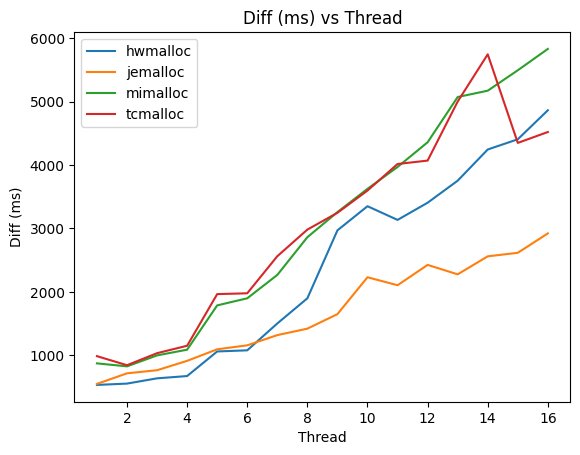

In [ ]:
## Plot diff over threads

plt.plot(hw_thread, hw_diff, label='hwmalloc')
plt.plot(je_thread, je_diff, label='jemalloc')
plt.plot(mi_thread, mi_diff, label='mimalloc')
plt.plot(tc_thread, tc_diff, label='tcmalloc')

# Set labels and title
plt.xlabel('Thread')
plt.ylabel('Diff (ms)')
plt.title('Diff (ms) vs Thread')

#Display the legend
plt.legend()

# Display the plot
plt.show()

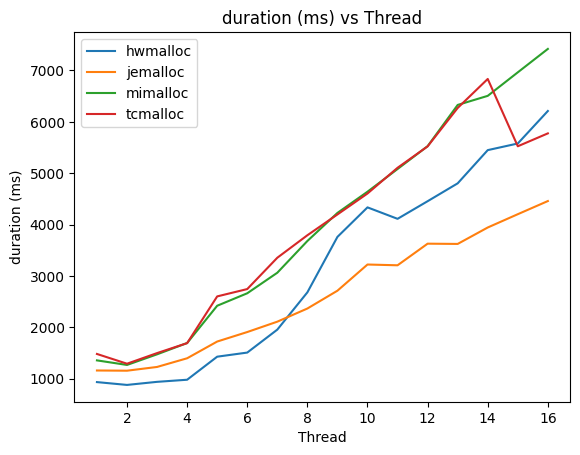

In [ ]:
## Plot duration over threads

plt.plot(hw_thread, hw_duration, label='hwmalloc')
plt.plot(je_thread, je_duration, label='jemalloc')
plt.plot(mi_thread, mi_duration, label='mimalloc')
plt.plot(tc_thread, tc_duration, label='tcmalloc')

# Set labels and title
plt.xlabel('Thread')
plt.ylabel('duration (ms)')
plt.title('duration (ms) vs Thread')

#Display the legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
## Plot duration_void over threads

plt.plot(hw_thread, hw_duration_of_void, label='hwmalloc')
plt.plot(je_thread, je_duration_of_void, label='jemalloc')
plt.plot(mi_thread, mi_duration_of_void, label='mimalloc')
plt.plot(tc_thread, tc_duration_of_void, label='tcmalloc')

# Set labels and title
plt.xlabel('Thread')
plt.ylabel('duration_of_void (ms)')
plt.title('duration_of_void (ms) vs Thread')

#Display the legend
plt.legend()

# Display the plot
plt.show()

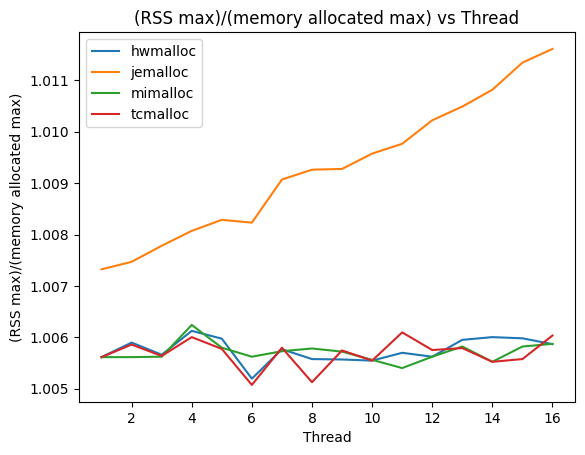

In [ ]:
## Plot memory usage over threads

plt.plot(hw_thread, hw_RSSmax_over_allocatedMax, label='hwmalloc')
plt.plot(je_thread, je_RSSmax_over_allocatedMax, label='jemalloc')
plt.plot(mi_thread, mi_RSSmax_over_allocatedMax, label='mimalloc')
plt.plot(tc_thread, tc_RSSmax_over_allocatedMax, label='tcmalloc')

# Set labels and title
plt.xlabel('Thread')
plt.ylabel('(RSS max)/(memory allocated max)')
plt.title('(RSS max)/(memory allocated max) vs Thread')

#Display the legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
## Plot diff over threads

plt.plot(je_thread, je_diff, label='jemalloc')
plt.plot(fancy_je_thread, fancy_je_diff, label='fancy jemalloc')

# Set labels and title
plt.xlabel('Thread')
plt.ylabel('Diff (ms)')
plt.title('Diff (ms) vs Thread')

#Display the legend
plt.legend()

# Display the plot
plt.show()